In [1]:
import requests
from requests.auth import HTTPBasicAuth
from urllib.parse import urlencode
import datetime as dt

import pandas as pd
import geopandas

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

In [2]:
# Run for local database
HOST = 'http://localhost'
auth = None

In [188]:
# Run for hosted database
HOST = 'https://esida.informatik.haw-hamburg.de'
auth = HTTPBasicAuth('esida', 'opendata22')

# Get Shapes from database

In [32]:
# Parameters:
# - type=region|district (optional)
# - wkt (optional, returns Geometry)
q = {
    #'type': 'region',
    'wkt': True
}
d = requests.get(f"{HOST}/api/v1/shapes?{urlencode(q)}", auth=auth).json()

# DataFrame
regions_gdf = geopandas.GeoDataFrame(d['data'])
if q['wkt']:
    regions_gdf['geometry'] = geopandas.GeoSeries.from_wkt(regions_gdf['wkt'])
    regions_gdf = regions_gdf.drop(columns=['wkt'])

In [33]:
regions_gdf

,area_sqm,id,name,type,geometry
0,4.194073e+10,1,Dodoma,region,"MULTIPOLYGON (((36.31609 -5.52782, 36.31818 -5..."
1,3.703191e+10,2,Arusha,region,"POLYGON ((35.83179 -3.42883, 35.83153 -3.42867..."
2,1.318330e+10,3,Kilimanjaro,region,"POLYGON ((38.39026 -4.10047, 38.40446 -4.11112..."
3,2.787135e+10,4,Tanga,region,"POLYGON ((37.76613 -5.01153, 37.76672 -5.01223..."
4,7.016366e+10,5,Morogoro,region,"MULTIPOLYGON (((37.43550 -8.54236, 37.43420 -8..."
...,...,...,...,...,...
221,1.047057e+08,222,Magharibi A,district,"POLYGON ((39.27725 -6.17416, 39.27696 -6.17398..."
222,2.309093e+08,223,Micheweni,district,"POLYGON ((39.68494 -4.87277, 39.68504 -4.87295..."
223,2.948198e+08,224,Wete,district,"MULTIPOLYGON (((39.68100 -5.13949, 39.68052 -5..."
224,2.189550e+08,225,Chake Chake,district,"POLYGON ((39.77278 -5.16294, 39.77408 -5.16319..."


In [5]:
regions = dict(zip(regions_gdf.id, regions_gdf.name))

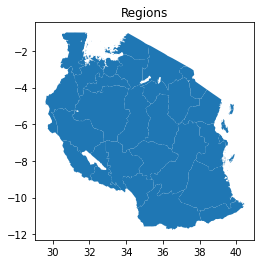

In [6]:
regions_gdf.plot()
plt.title('Regions')
plt.show()

# Load popc

In [20]:
parameter_id = 'worldpop_popc'
q = {
    'start_date': '2020', # optional
    'end_date': '2020' # optional
}
d = requests.get(f"{HOST}/api/v1/parameter/{parameter_id}?{urlencode(q)}", auth=auth).json()
popc_df = pd.DataFrame(d['data'])
shape_ids = param_df['shape_id'].unique()

In [14]:
# print available fields
print(d['fields'])

['worldpop_popc']


# Load sexage

In [21]:
parameter_id = 'worldpop_sexage'
q = {
    'start_date': '2020', # optional
    'end_date': '2020' # optional
}
d = requests.get(f"{HOST}/api/v1/parameter/{parameter_id}?{urlencode(q)}", auth=auth).json()
sexage_df = pd.DataFrame(d['data'])
shape_ids = param_df['shape_id'].unique()

# Merge

In [22]:
sexage_df

,shape_id,worldpop_sexage,year
0,1,2461147.800,2020
1,2,2116506.200,2020
2,3,1881900.400,2020
3,4,2450000.500,2020
4,5,2688387.000,2020
...,...,...,...
221,222,229790.860,2020
222,223,114582.984,2020
223,224,106638.086,2020
224,225,107358.610,2020


In [23]:
popc_df

,shape_id,worldpop_popc,year
0,1,2604209.20,2020
1,2,2239535.00,2020
2,3,1991291.50,2020
3,4,2592411.50,2020
4,5,2844658.00,2020
...,...,...,...
221,222,243148.08,2020
222,223,121243.45,2020
223,224,112836.73,2020
224,225,113599.13,2020


In [42]:
df = popc_df.merge(sexage_df[['worldpop_sexage', 'shape_id']], on='shape_id')

In [105]:
df['delta'] = df['worldpop_popc'] -  df['worldpop_sexage']
df['delta_pct'] =   df['worldpop_sexage'] / df['worldpop_popc']

In [44]:
regions_gdf['shape_id'] = regions_gdf['id']
df = df.merge(regions_gdf, on='shape_id')

In [45]:
df

,shape_id,worldpop_popc,year,worldpop_sexage,delta,area_sqm,id,name,type,geometry
0,1,2604209.20,2020,2461147.800,143061.400,4.194073e+10,1,Dodoma,region,"MULTIPOLYGON (((36.31609 -5.52782, 36.31818 -5..."
1,2,2239535.00,2020,2116506.200,123028.800,3.703191e+10,2,Arusha,region,"POLYGON ((35.83179 -3.42883, 35.83153 -3.42867..."
2,3,1991291.50,2020,1881900.400,109391.100,1.318330e+10,3,Kilimanjaro,region,"POLYGON ((38.39026 -4.10047, 38.40446 -4.11112..."
3,4,2592411.50,2020,2450000.500,142411.000,2.787135e+10,4,Tanga,region,"POLYGON ((37.76613 -5.01153, 37.76672 -5.01223..."
4,5,2844658.00,2020,2688387.000,156271.000,7.016366e+10,5,Morogoro,region,"MULTIPOLYGON (((37.43550 -8.54236, 37.43420 -8..."
...,...,...,...,...,...,...,...,...,...,...
221,222,243148.08,2020,229790.860,13357.220,1.047057e+08,222,Magharibi A,district,"POLYGON ((39.27725 -6.17416, 39.27696 -6.17398..."
222,223,121243.45,2020,114582.984,6660.466,2.309093e+08,223,Micheweni,district,"POLYGON ((39.68494 -4.87277, 39.68504 -4.87295..."
223,224,112836.73,2020,106638.086,6198.644,2.948198e+08,224,Wete,district,"MULTIPOLYGON (((39.68100 -5.13949, 39.68052 -5..."
224,225,113599.13,2020,107358.610,6240.520,2.189550e+08,225,Chake Chake,district,"POLYGON ((39.77278 -5.16294, 39.77408 -5.16319..."


In [46]:
gdf = geopandas.GeoDataFrame(df)

Text(0.5, 1.0, 'Delta 2020 popc and sexage')

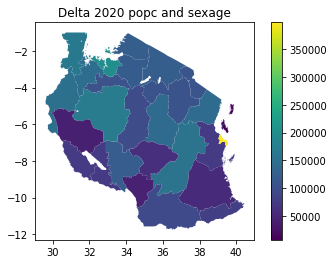

In [51]:
gdf[gdf['type'] == 'region'].plot(column='delta', legend=True)
plt.title('Delta 2020 popc and sexage')
plt.show()

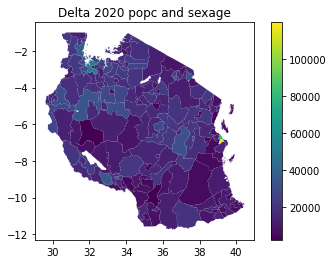

In [53]:
gdf[gdf['type'] == 'district'].plot(column='delta', legend=True)
plt.title('Delta 2020 popc and sexage')
plt.show()

In [83]:
gdf['delta_pct'] =   gdf['worldpop_sexage'] / gdf['worldpop_popc']

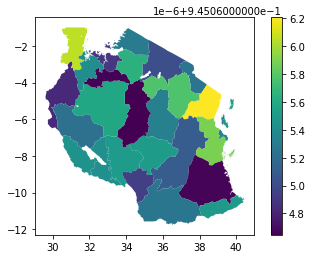

In [112]:
gdf[gdf['type'] == 'region'].plot(column='delta_pct', legend=True)
#plt.title('Delta 2020 popc and sexage')
plt.show()

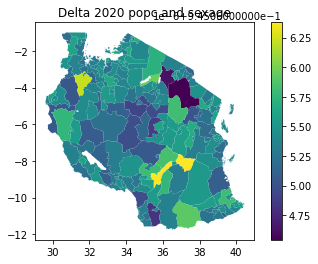

In [85]:
gdf[gdf['type'] == 'district'].plot(column='delta_pct', legend=True)
plt.title('Delta 2020 popc and sexage')
plt.show()

In [114]:
gdf

,shape_id,worldpop_popc,year,worldpop_sexage,delta,area_sqm,id,name,type,geometry,delta_pct,delta_pct2
0,1,2604209.20,2020,2461147.800,143061.400,4.194073e+10,1,Dodoma,region,"MULTIPOLYGON (((36.31609 -5.52782, 36.31818 -5...",0.945065,0.054935
1,2,2239535.00,2020,2116506.200,123028.800,3.703191e+10,2,Arusha,region,"POLYGON ((35.83179 -3.42883, 35.83153 -3.42867...",0.945065,0.054935
2,3,1991291.50,2020,1881900.400,109391.100,1.318330e+10,3,Kilimanjaro,region,"POLYGON ((38.39026 -4.10047, 38.40446 -4.11112...",0.945065,0.054935
3,4,2592411.50,2020,2450000.500,142411.000,2.787135e+10,4,Tanga,region,"POLYGON ((37.76613 -5.01153, 37.76672 -5.01223...",0.945066,0.054934
4,5,2844658.00,2020,2688387.000,156271.000,7.016366e+10,5,Morogoro,region,"MULTIPOLYGON (((37.43550 -8.54236, 37.43420 -8...",0.945065,0.054935
...,...,...,...,...,...,...,...,...,...,...,...,...
221,222,243148.08,2020,229790.860,13357.220,1.047057e+08,222,Magharibi A,district,"POLYGON ((39.27725 -6.17416, 39.27696 -6.17398...",0.945065,0.054935
222,223,121243.45,2020,114582.984,6660.466,2.309093e+08,223,Micheweni,district,"POLYGON ((39.68494 -4.87277, 39.68504 -4.87295...",0.945065,0.054935
223,224,112836.73,2020,106638.086,6198.644,2.948198e+08,224,Wete,district,"MULTIPOLYGON (((39.68100 -5.13949, 39.68052 -5...",0.945065,0.054935
224,225,113599.13,2020,107358.610,6240.520,2.189550e+08,225,Chake Chake,district,"POLYGON ((39.77278 -5.16294, 39.77408 -5.16319...",0.945065,0.054935


In [86]:
gdf['delta_pct'].min()

0.945064542471353

In [87]:
gdf['delta_pct'].max()

0.9450663781221154

In [88]:
gdf['delta_pct2'] = 1 - gdf['delta_pct']

In [91]:
gdf['delta_pct2'].mean()

0.054934618314660795

<AxesSubplot:xlabel='name'>

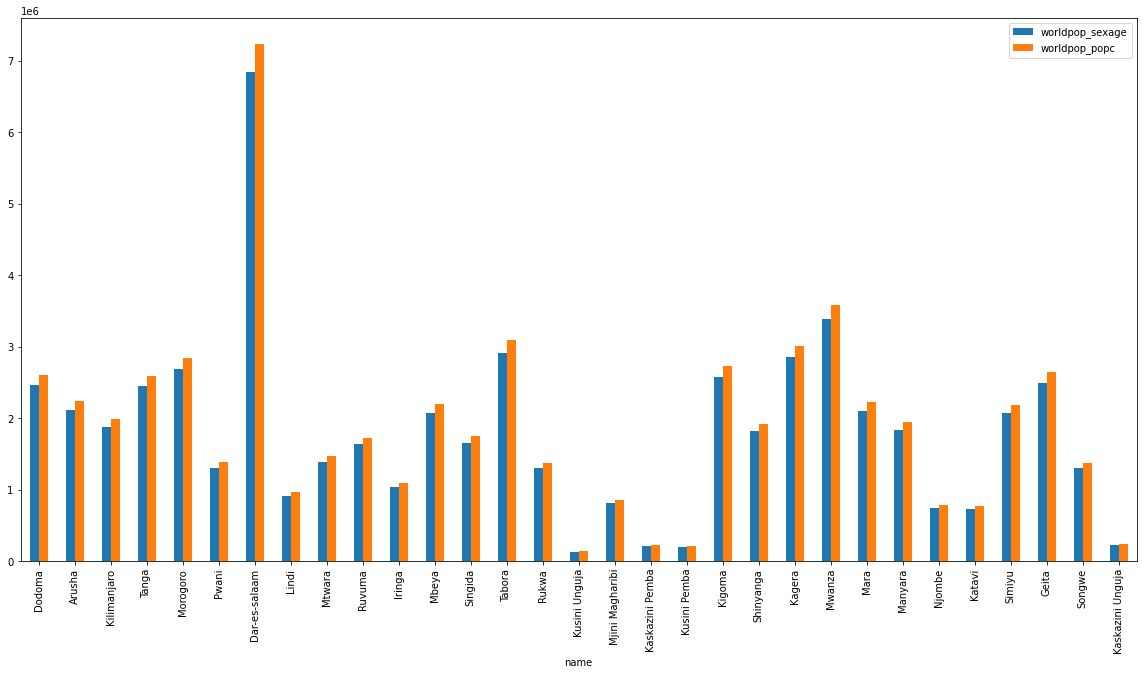

In [101]:
df[df['type'] == 'region'].plot.bar(x='name', y=['worldpop_sexage', 'worldpop_popc' ], figsize=(20, 10))

<AxesSubplot:xlabel='name'>

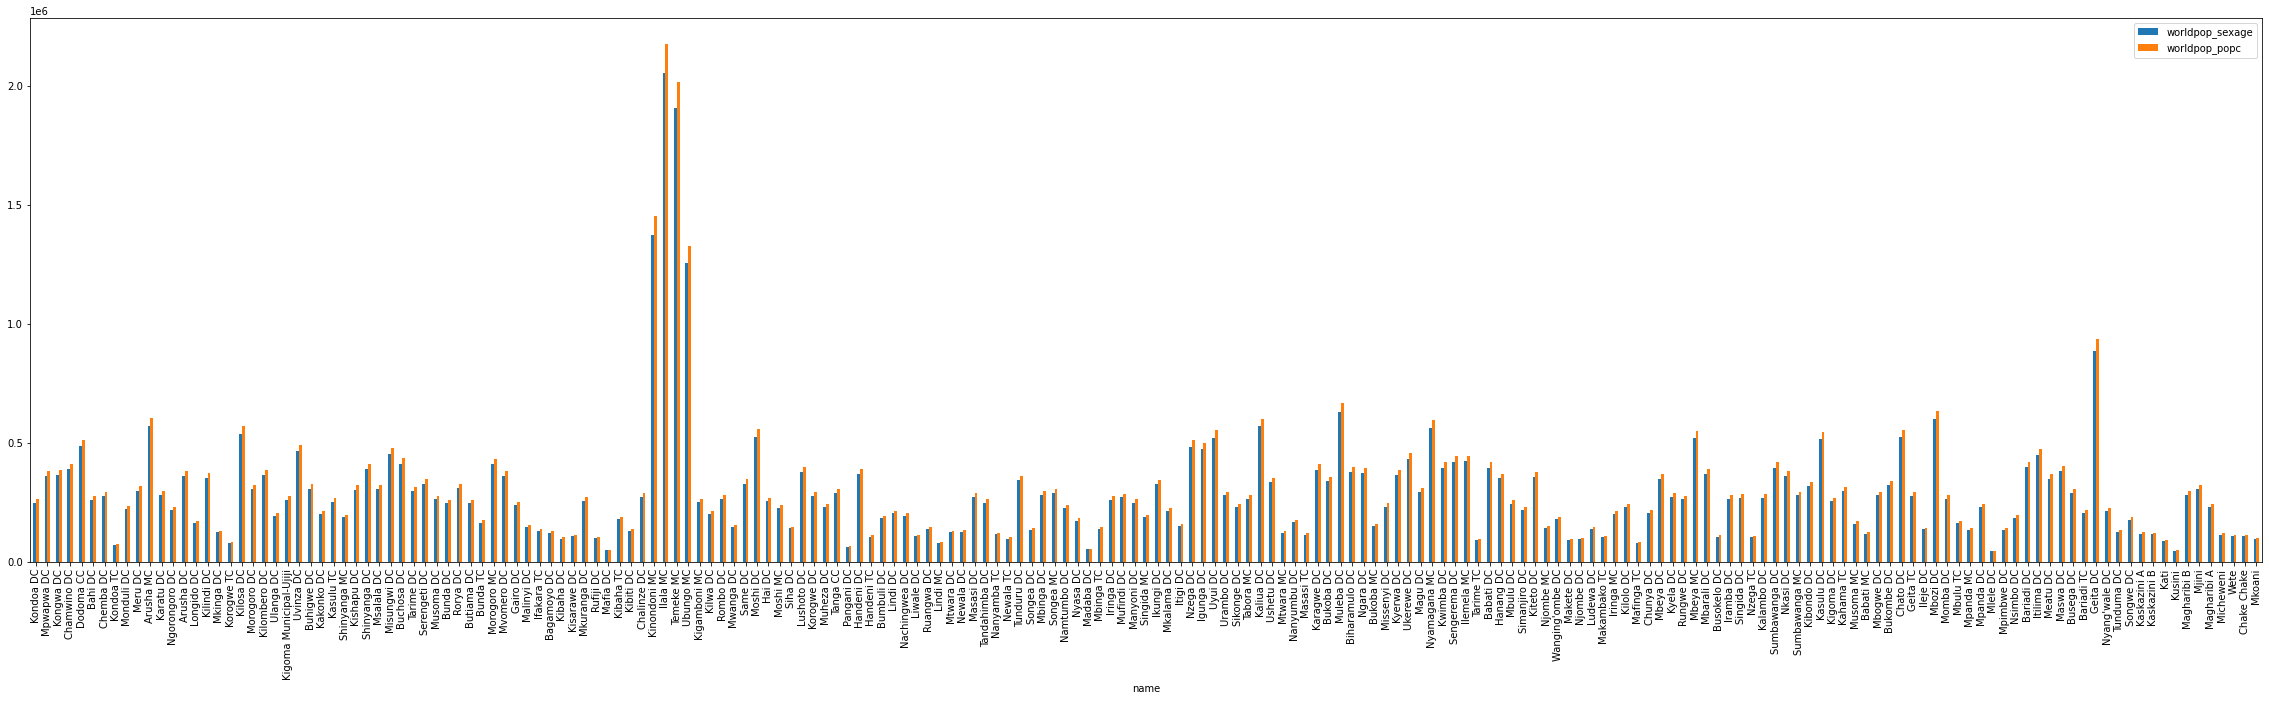

In [103]:
df[df['type'] == 'district'].plot.bar(x='name', y=['worldpop_sexage', 'worldpop_popc' ], figsize=(40, 10))

<AxesSubplot:xlabel='name'>

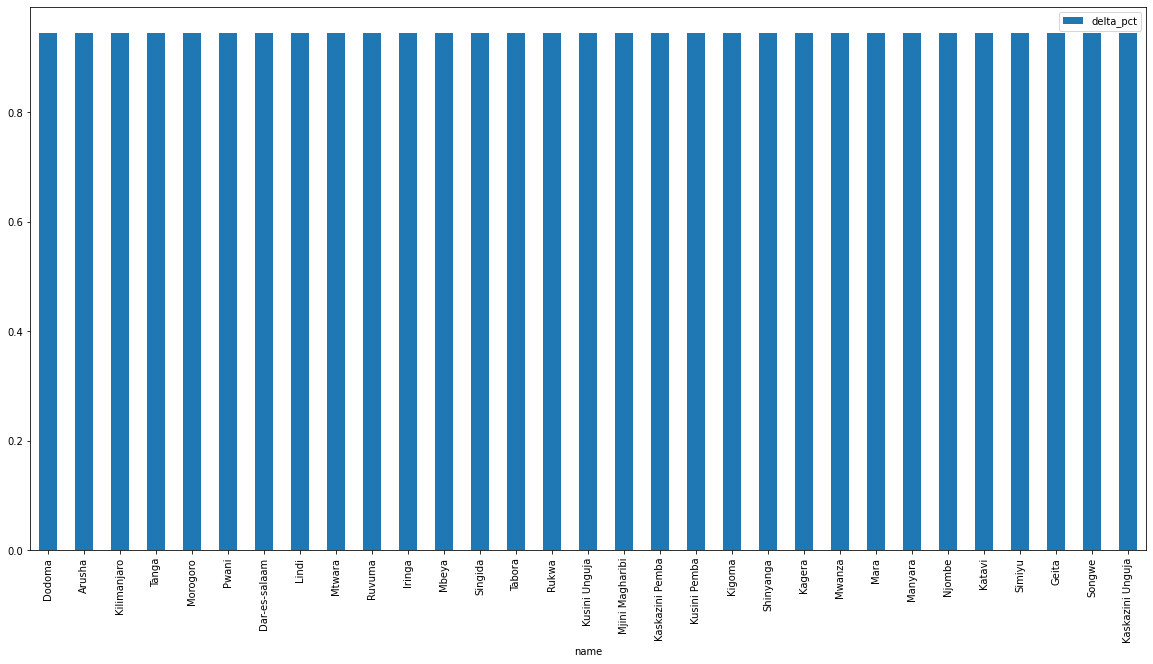

In [108]:
df[df['type'] == 'region'].plot.bar(x='name', y=['delta_pct' ], figsize=(20, 10))

<AxesSubplot:xlabel='name'>

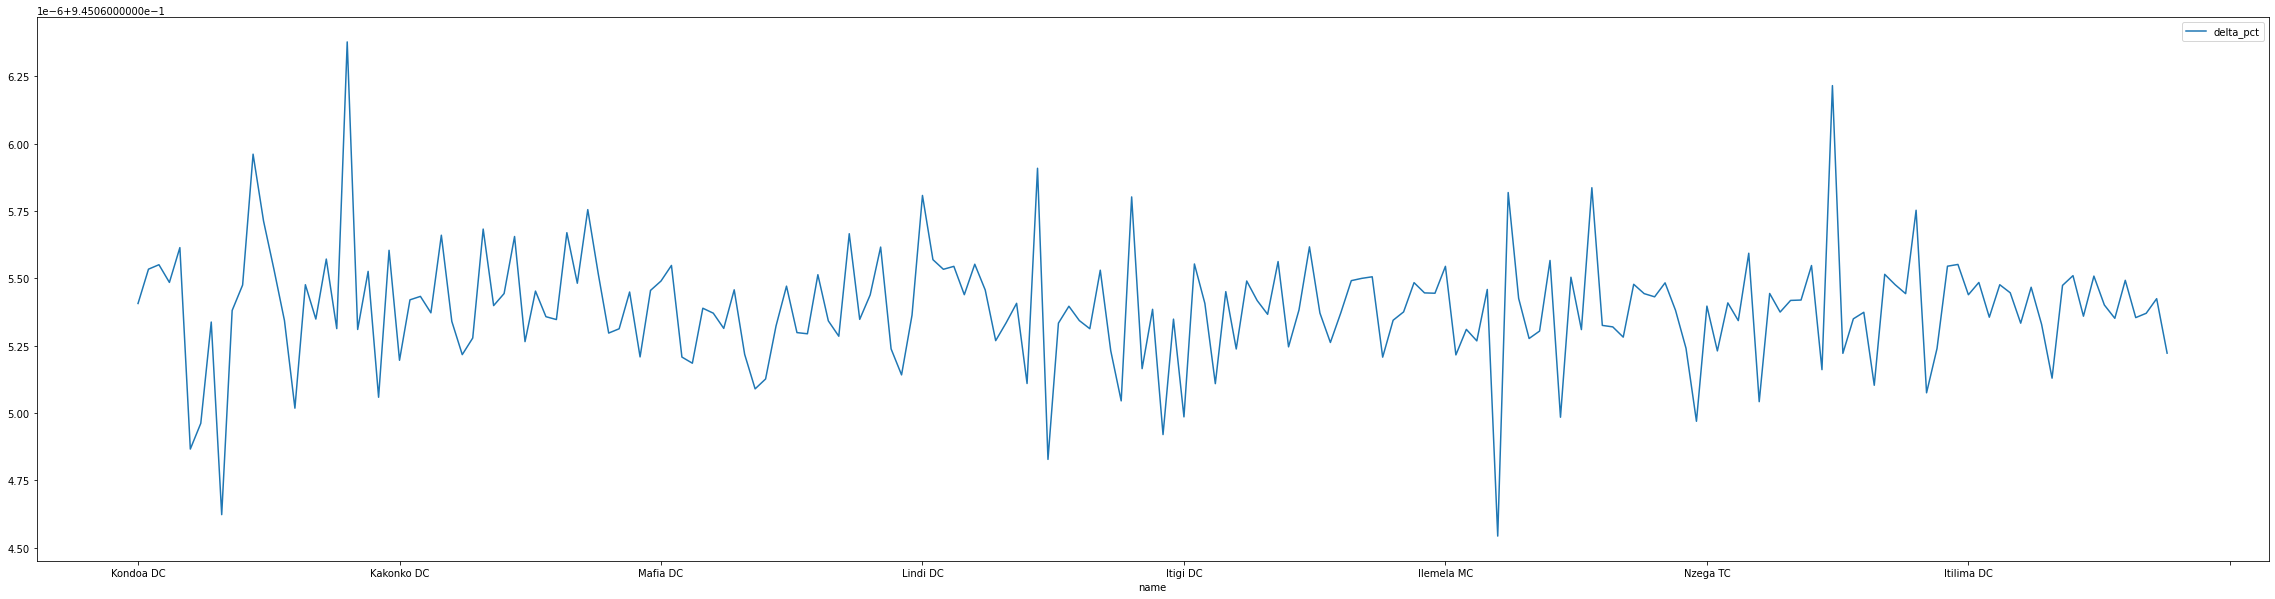

In [113]:
df[df['type'] == 'district'].plot.line(x='name', y=['delta_pct' ], figsize=(40, 10))